In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python



# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [2]:
# Importing the libraries

import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
sns.set()

In [3]:
# Importing the train and test sets

train_df = pd.read_csv("../input/house-prices-advanced-regression-techniques/train.csv")
test_df = pd.read_csv("../input/house-prices-advanced-regression-techniques/test.csv")
train = train_df.copy()
test = test_df.copy()
print("Size of training set:", train.shape)
print("Size of testing set:", test.shape)
print("\n\n")
train.head()

Size of training set: (1460, 81)
Size of testing set: (1459, 80)





,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
# Getting the information and some basic statistics from the training dataset

print(train.describe())
print("\n\n")
print(train.info())

                Id   MSSubClass  LotFrontage        LotArea  OverallQual  \
count  1460.000000  1460.000000  1201.000000    1460.000000  1460.000000   
mean    730.500000    56.897260    70.049958   10516.828082     6.099315   
std     421.610009    42.300571    24.284752    9981.264932     1.382997   
min       1.000000    20.000000    21.000000    1300.000000     1.000000   
25%     365.750000    20.000000    59.000000    7553.500000     5.000000   
50%     730.500000    50.000000    69.000000    9478.500000     6.000000   
75%    1095.250000    70.000000    80.000000   11601.500000     7.000000   
max    1460.000000   190.000000   313.000000  215245.000000    10.000000   

       OverallCond    YearBuilt  YearRemodAdd   MasVnrArea   BsmtFinSF1  ...  \
count  1460.000000  1460.000000   1460.000000  1452.000000  1460.000000  ...   
mean      5.575342  1971.267808   1984.865753   103.685262   443.639726  ...   
std       1.112799    30.202904     20.645407   181.066207   456.098091  ..

# EDA & Visualization

In [5]:
# Functions needed for EDA

def subplot_num(col_num):
    """
    Accepts number of columns (6 or more) for visualization 
    and claculates numbers of subplots required.
    
    Parameters
    ----------
    col_num: Int, number of columns to be visualized
    
    Returns
    ----------
    Two integers first for fig, second for ax
    """
    fig, ax = 0, 0
    
    if col_num > 6:
        fig = (col_num // 6) + 1
        ax = 6
        
    else:
        fig, ax = 1, col_num
    
    return (fig, ax)

def numeric_corr(data, height = 15, width = 15):
    """
    Accpets numerical data and calculates Pearson correlation
    for the variables.
    
    Parameters
    ----------
    data: Pandas dataframe, only including the numerical data
    height: Int, specifies the height of the heatmap. 15 by default
    width: Int, specifies the width of the heatmap. 15 by default
    
    Returns
    ----------
    Seaborn heatmap plot
    """
    mask = np.triu(np.ones_like(data.corr(), dtype = bool))
    plt.figure(dpi = 100, figsize = (height, width))
    plt.title("Pearson Correlation Analysis")
    sns.heatmap(data.corr().round(2), mask = mask, annot = True, lw = 0.1, linecolor = "black",
			cmap = "viridis", annot_kws = {"size": 8})

    # Next line is optional. If the cell size of the geat map are not fit for the text, change it.
    # sns.set(font_scale = 1.1)
    plt.xticks()
    plt.yticks(rotation = 0)
    plt.show()
    

def basic_details(data):
    """
    Accepts data and calculates number of missing values, unique values, 
    data type, skewness and kurtosis for each column.
    
    Parameters
    ----------
    data: Pandas dataframe
    
    Returns
    ----------
    Pands dataframe including five columns
    """
    res = pd.DataFrame()
    res['Missing Value'] = data.isnull().sum()
    res['Unique Value'] = data.nunique()
    res['Data Type'] = data.dtypes
    res["Skewness"] = data.skew(numeric_only = True)
    res["Kurtosis"] = data.kurt(numeric_only = True)
    return res  

In [6]:
# Separating numerical and categorical columns

numeric = [x for x in train.columns if train[x].dtypes != "object"]
categoric = [x for x in train.columns if train[x].dtypes == "object"]
target = "SalePrice"

In [7]:
# Deleting Id column from the numeric list

del numeric[0]

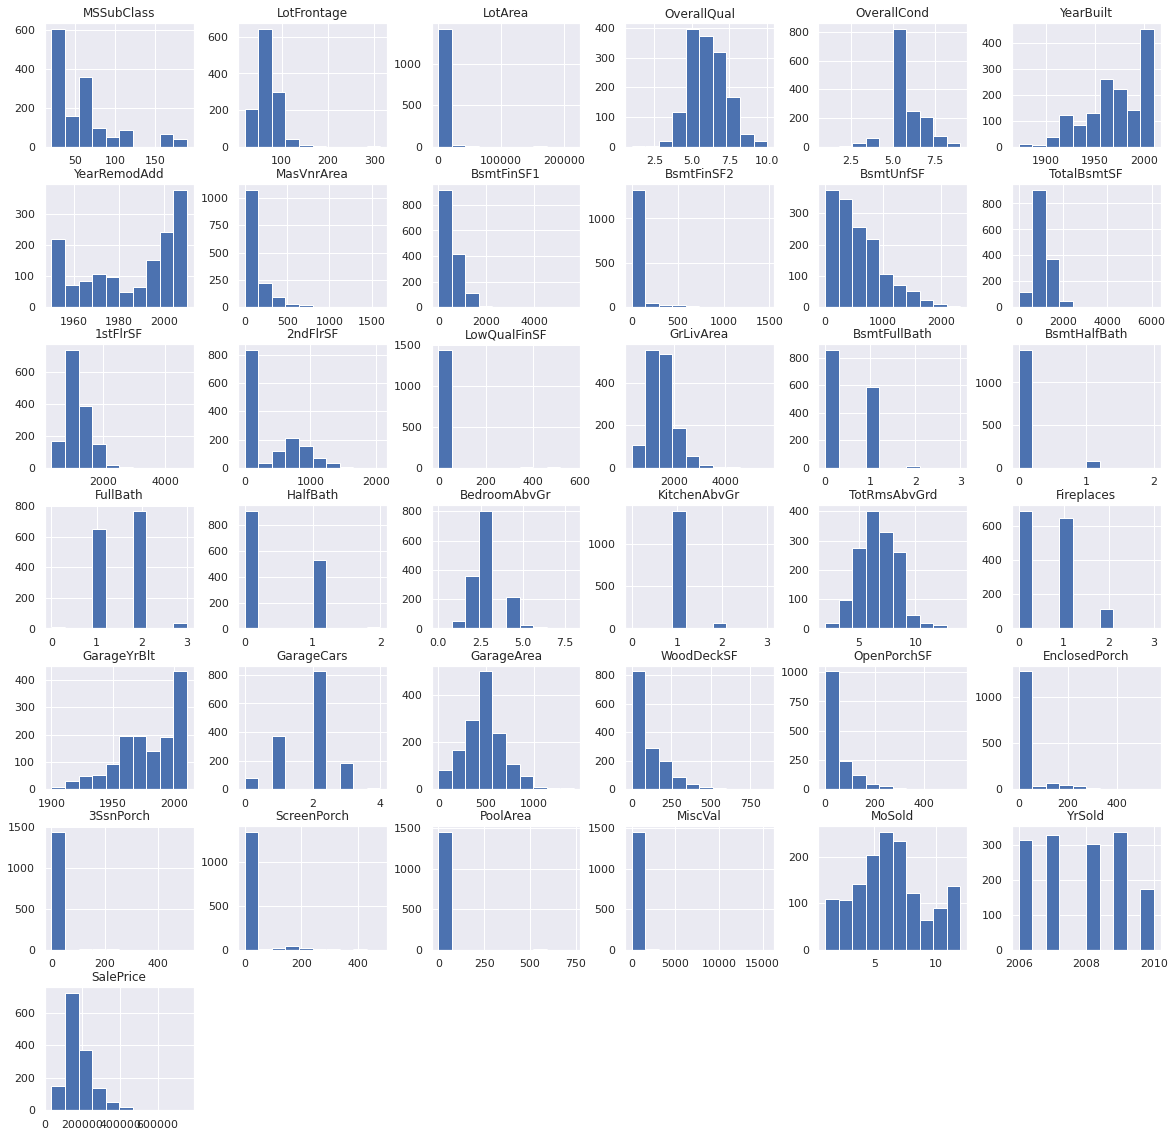

In [8]:
# Visualizing all numeric columns

_ = train[numeric].hist(figsize = (20, 20))

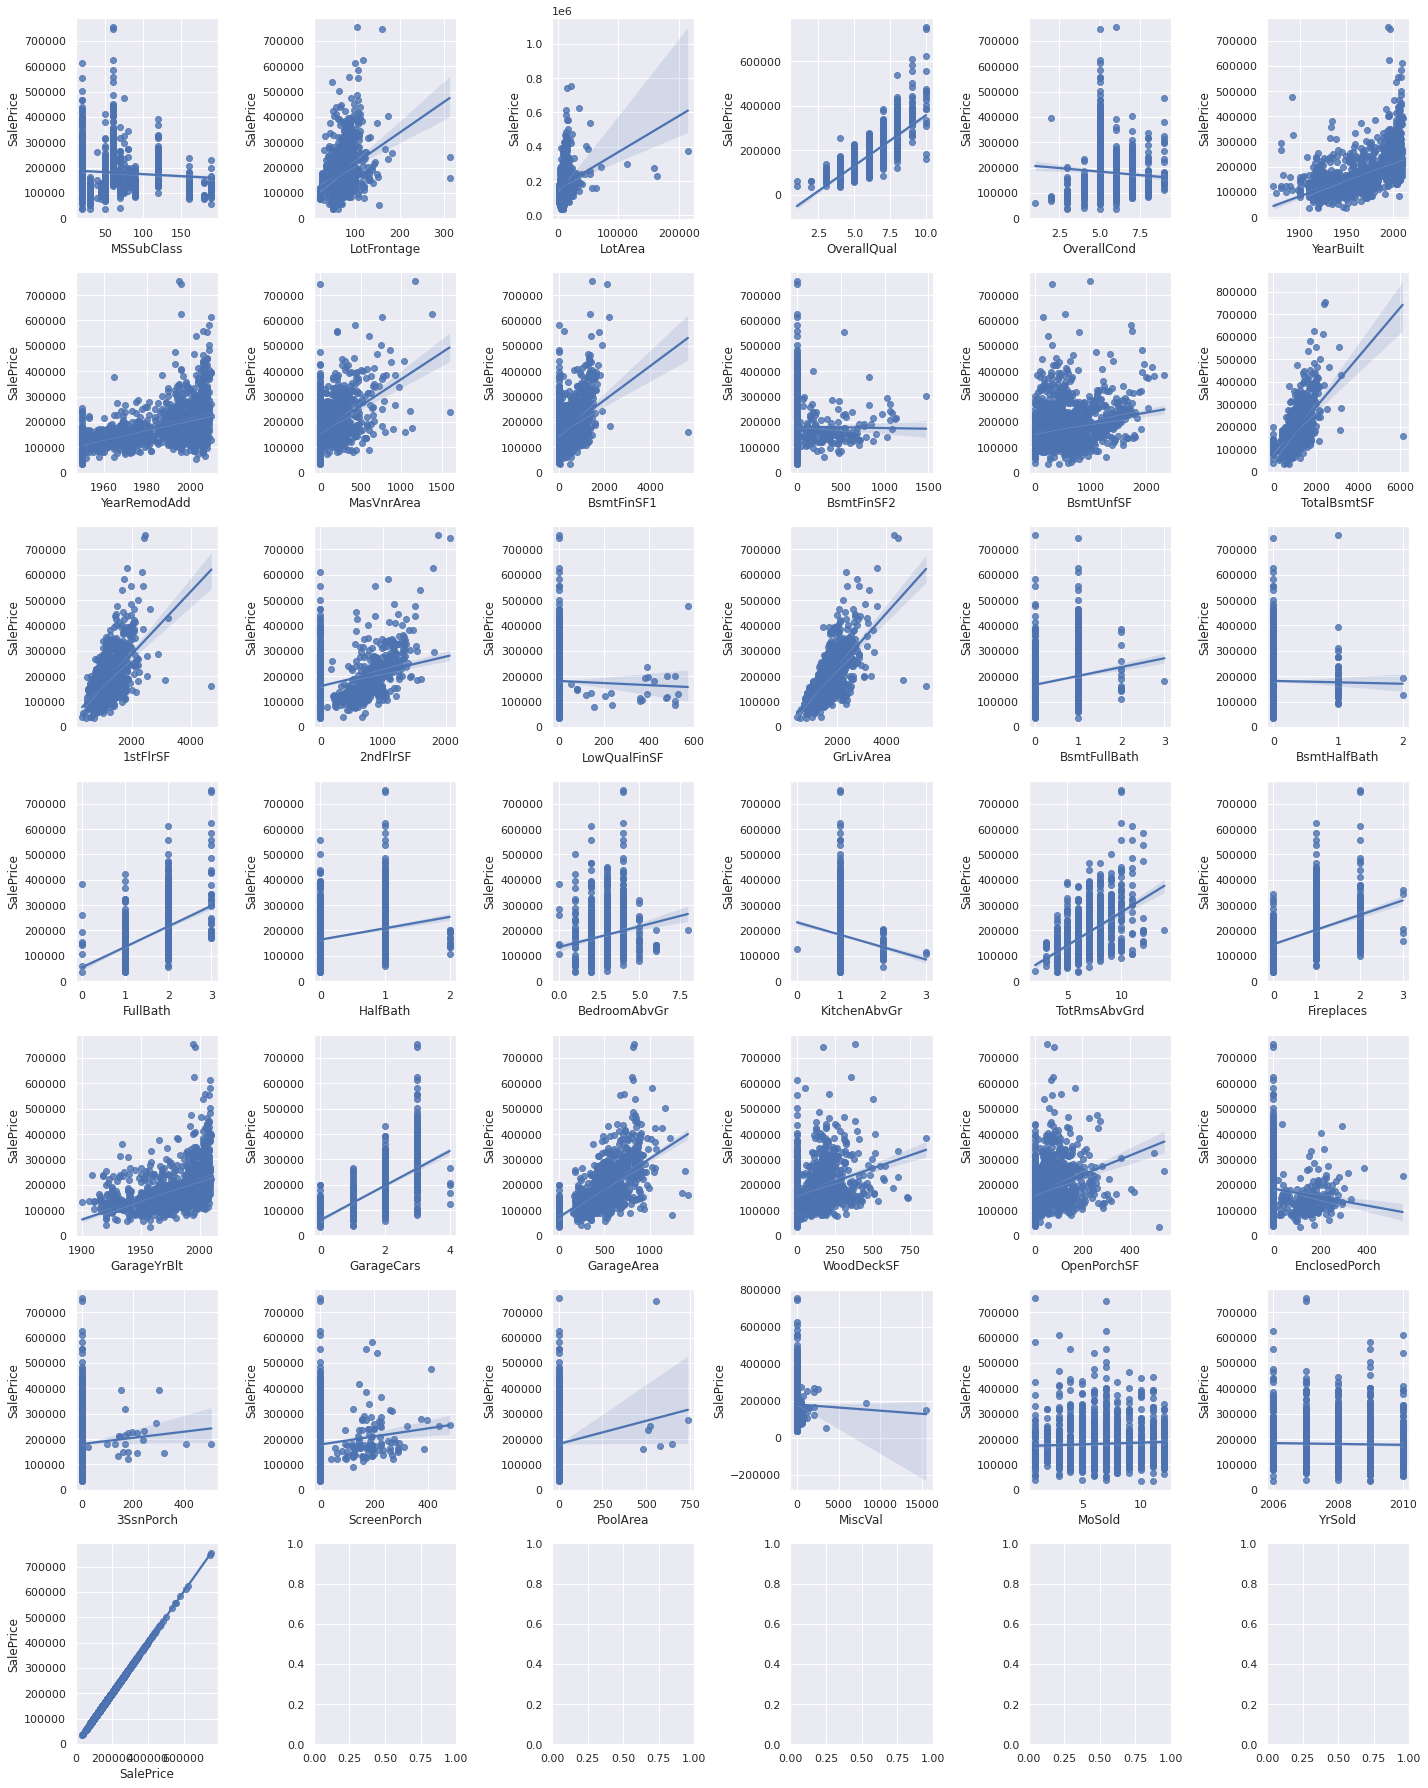

In [9]:
# Discovering if there is a linear relation between the numerical values of the dataset 
#      and the target variable

fig, ax = subplot_num(len(numeric))
fig, axs = plt.subplots(fig, ax, figsize = (20, 25))


for ax, i in zip(axs.flat, range(len(numeric))):
    sns.regplot(x = numeric[i], y = target, data = train[numeric], ax = ax)
    
    
plt.tight_layout()    
plt.show()

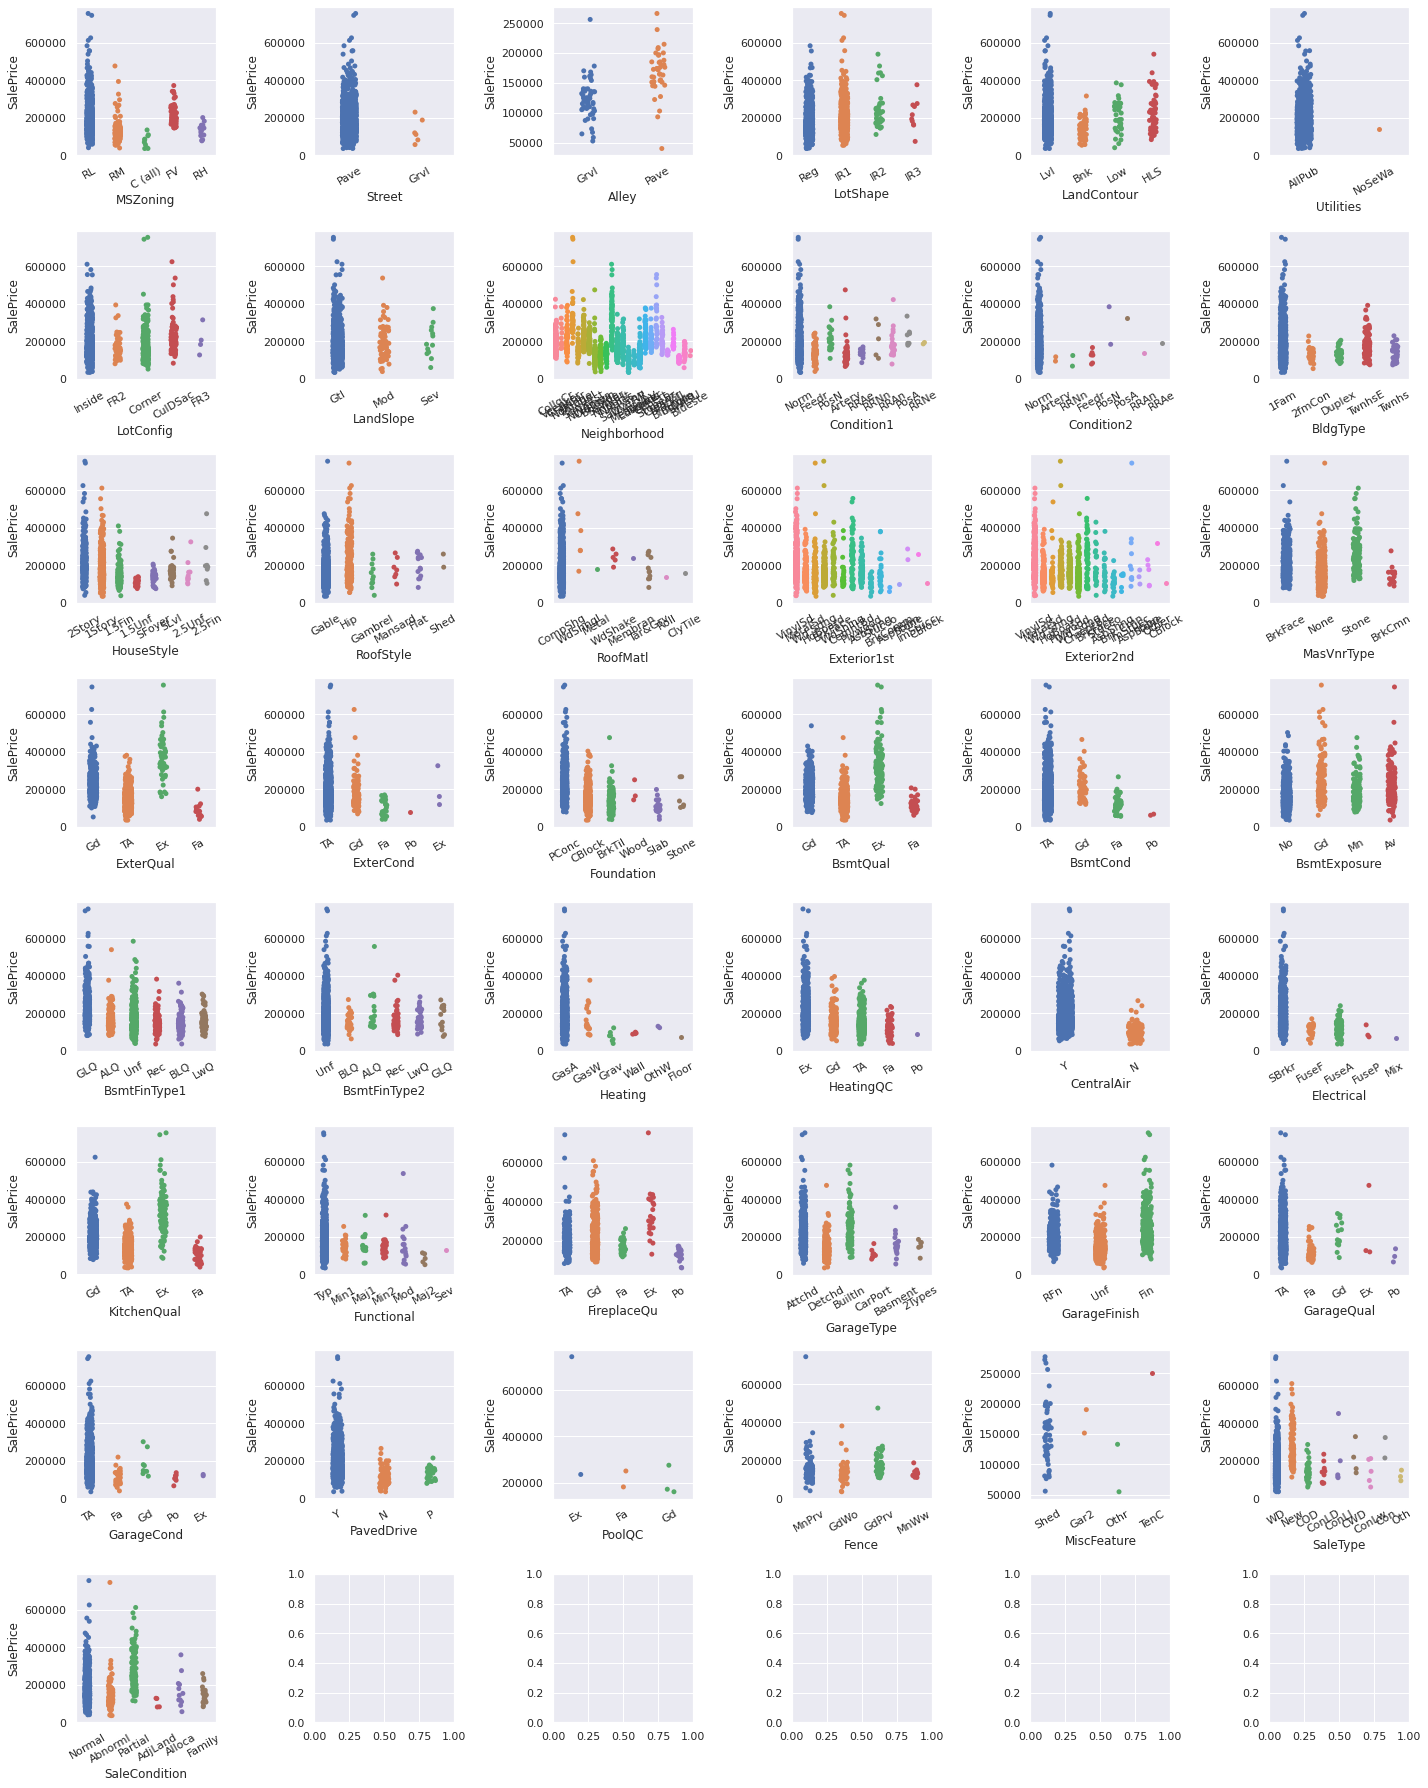

In [10]:
# Visualizing the relation between the categorical variables of the dataset and the target variable

fig, ax = subplot_num(len(categoric))
fig, axs = plt.subplots(fig, ax, figsize = (20, 25))


for ax, i in zip(axs.flat, range(len(categoric))):
    sns.stripplot(x = categoric[i], y = target, data = train, ax = ax, )
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 30)
    
plt.tight_layout()    
plt.show()

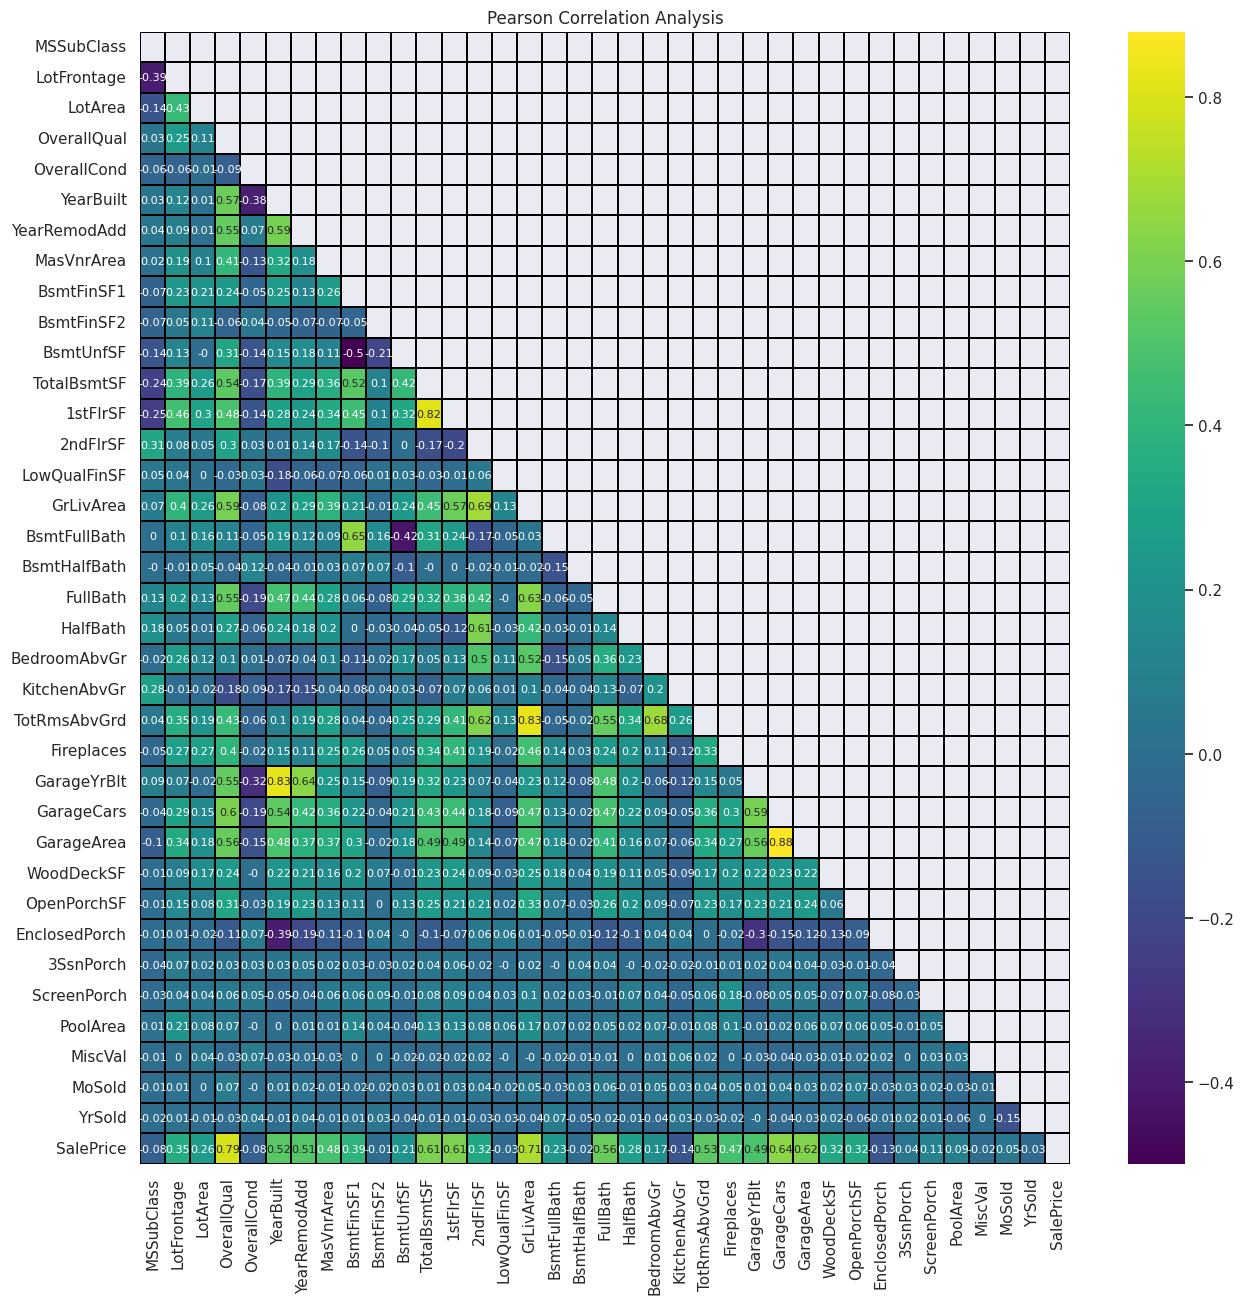

In [11]:
# Visualizing the Pearson correlation between numerical features

numeric_corr(train[numeric])

In [12]:
stats = basic_details(train)
stats.head()

,Missing Value,Unique Value,Data Type,Skewness,Kurtosis
Id,0,1460,int64,0.000000,-1.200000
MSSubClass,0,15,int64,1.407657,1.580188
MSZoning,0,5,object,NaN,NaN
LotFrontage,259,110,float64,2.163569,17.452867
LotArea,0,1073,int64,12.207688,203.243271


https://www.kaggle.com/code/marto24/beginners-prediction-top3
    
https://www.kaggle.com/code/dmkravtsov/3-2-house-prices/notebook
    
https://www.kaggle.com/code/darkside92/detailed-examination-for-house-price-top-10

https://www.kaggle.com/code/ankitverma2010/house-price-prediction-ensemble-methods